In [9]:
%matplotlib notebook

In [1]:
import os
import pickle

import numpy as np

from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt

from shared_code import check_pershombox_availability
check_pershombox_availability()
from pershombox import calculate_discrete_NPHT_2d

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split

# from joblib import parallel_backend
from joblib import Parallel, delayed

import xgboost as xgb

In [4]:
help(calculate_discrete_NPHT_2d)

Help on function calculate_discrete_NPHT_2d in module pershombox.pht:

calculate_discrete_NPHT_2d(binary_cubical_complex: <built-in function array>, number_of_directions) -> list
    Calculates NPHT for 2d cubical complexes with equidistant directions.
    
    :param binary_cubical_complex:
    :param number_of_directions:
    :return:



In [3]:
data_root = os.path.join("..", "assets", "animal")
classes = [f for f in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, f))]

In [4]:
print(len(classes), "classes")
labels = [c_i for c_i, _ in enumerate(classes)]

20 classes


In [6]:
X, y = [], []
n_directions = 1
debug = False

for c_i, c in enumerate(classes):
    
    c_path = os.path.join(data_root, c)
    
    for f in tqdm(os.listdir(c_path)):
        if os.path.isfile(os.path.join(c_path, f)) and f[-4:] == ".tif":
            im_path = os.path.join(c_path, f)
            im = Image.open(im_path)
            imarray = np.array(im.convert('L')).astype(np.uint8)
            
            pdgm = calculate_discrete_NPHT_2d(imarray, n_directions)
            X.append(pdgm)
            y.append(c_i)
            if debug:
                break


backend threads

n_jobs=6 => 35 sec.
n_jobs=1 => 46 sec.

backend processes

n_jobs=8 => 12 sec.
n_jobs=12 => 10 sec.

In [51]:
%timeit

def get_pdgm(data_rooth, c, c_i, n_dir, debug=True):
    X, y = [], []
    
    c_path = os.path.join(data_root, c)
    n_files = sum([1 for f in os.listdir(c_path) if f[-4:] == ".tif"])
    
    for i, f in enumerate(os.listdir(c_path)):
        
        if os.path.isfile(os.path.join(c_path, f)) and f[-4:] == ".tif":
            
            im_path = os.path.join(c_path, f)
            im = Image.open(im_path)
            imarray = np.array(im.convert('L')).astype(np.uint8)
            
            pdgm = calculate_discrete_NPHT_2d(imarray, n_dir)
            X.append(pdgm)
            y.append(c_i)
            if i % 10 == 0:
                print(f"{c_i} => Classe '{c}' computed {(i+1)/n_files}")
            if debug:
                break
    return X, y

n_dir = 16
debug = False

with Parallel(n_jobs=10, prefer="processes") as parallel:

    res = parallel(delayed(get_pdgm)(data_root, c, c_i, n_dir, debug) for c_i, c in enumerate(classes))

X, y = [], []
for X_, y_ in res:
    X.extend(X_)
    y.extend(y_)

print(len(X))
print(len(y))

if not(debug):
    with open(f'X_{n_dir}_dir.pkl', 'wb') as f:
        pickle.dump(X, f)
    
    with open(f'y_{n_dir}_dir.pkl', 'wb') as f:
        pickle.dump(y, f)

1997
1997


In [5]:
n_dir = 16

with open(f'X_{n_dir}_dir.pkl', "rb") as f:
    X = pickle.load(f)

with open(f'y_{n_dir}_dir.pkl', "rb") as f:
    y = pickle.load(f)
    
print(np.shape(X))
print(np.shape(y))

(1997, 16, 2)
(1997,)


/Users/romainegele/opt/anaconda3/envs/ph/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [6]:
N = 10
V = [] # vectorized persistence diagram
flatten = False
step = 2
add_h1 = False

def vectorize(h, size):
    tmp = [d-b for b,d in h]
    tmp.sort(reverse=True)
    if len(tmp) >= size:
        v = tmp[:size]
    else:
        v = tmp + [0]*(size-len(tmp))
    return v

for x in X:
    v_h0_list = []
    v_h1_list = []
    for i in range(0,len(x),step):
#         print(x)
        h0 = x[i][0] # homology of dim 0 in direction "i"
        
        v_h0 = vectorize(h0, N)
        v_h0_list.append(v_h0)
        
        if add_h1:
            h1 = x[i][1]
            v_h1 = vectorize(h1, N)
            v_h1_list.extend(v_h1)
        
    
    if add_h1:
        if len(v_h1_list) >= N:
            v_h1 = v_h1_list[:N]
        else:
            v_h1 = v_h1_list + [0]*(N-len(v_h1_list))
        
        v_h0_list.append(v_h1)
        
    if flatten:
        V.append(np.array(v_h0_list).flatten())
    else:
        V.append(np.array(v_h0_list))
    
V = np.array(V)
y = np.array(y)
print(np.shape(V))

(1997, 8, 10)


In [164]:
V_transformed = []
for vec_pdgm in V:
    v_list = []
    for i, v in enumerate(vec_pdgm):
        i_before = i-1
        i_after = (i+1)%n_dir
        v_concat = np.concatenate([vec_pdgm[i_before], v, vec_pdgm[i_after]], axis=-1)
        v_list.append(v_concat)
    V_transformed.append(v_list)

V_transformed = np.array(V_transformed)
print(np.shape(V_transformed))

(1997, 16, 30)


In [68]:
kf = KFold(n_splits=10, shuffle=True)

V = np.array(V)
y = np.array(y)

train_scores = []
test_scores = []

for train_index, test_index in kf.split(V):
    X_train, X_test = V[train_index], V[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cls = RandomForestClassifier(n_jobs=8, max_depth=9, n_estimators=100)
#     cls = SVC(kernel="linear")

    cls.fit(X_train, y_train)
    
    train_score = cls.score(X_train, y_train)
    test_score = cls.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

print(f"[{n_dir},{N}]")
print(f"TRAIN: {train_scores.mean():.3f} ± {train_scores.std():.3f}")
print(f"TEST : {test_scores.mean():.3f} ± {test_scores.std():.3f}")

[16,10]
TRAIN: 0.952 ± 0.000
TEST : 0.550 ± 0.000


In [65]:
X_train, X_test, y_train, y_test = train_test_split(V, y, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(np.shape(X_train))

n_units = 32

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=np.shape(X_train)[1:]),
  tf.keras.layers.Dense(n_units, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(n_units, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(n_units, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

hist1 = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=16,
    validation_data=(X_test, y_test),
    shuffle=True
)

(1800, 160)
Epoch 1/100
113/113 [==============================] - 0s 2ms/step - loss: 2.9814 - accuracy: 0.0739 - val_loss: 2.7852 - val_accuracy: 0.1600
Epoch 2/100
113/113 [==============================] - 0s 957us/step - loss: 2.7591 - accuracy: 0.1361 - val_loss: 2.5826 - val_accuracy: 0.1750
Epoch 3/100
113/113 [==============================] - 0s 897us/step - loss: 2.6325 - accuracy: 0.1544 - val_loss: 2.4221 - val_accuracy: 0.1950
Epoch 4/100
113/113 [==============================] - 0s 874us/step - loss: 2.4451 - accuracy: 0.2167 - val_loss: 2.2455 - val_accuracy: 0.2650
Epoch 5/100
113/113 [==============================] - 0s 890us/step - loss: 2.3468 - accuracy: 0.2456 - val_loss: 2.1281 - val_accuracy: 0.3150
Epoch 6/100
113/113 [==============================] - 0s 907us/step - loss: 2.2680 - accuracy: 0.2778 - val_loss: 2.0483 - val_accuracy: 0.3500
Epoch 7/100
113/113 [==============================] - 0s 1ms/step - loss: 2.1806 - accuracy: 0.3067 - val_loss: 1.9730 

In [66]:
compute_max = True
if compute_max:
    acc = max(hist1.history["accuracy"])
    val_acc = max(hist1.history["val_accuracy"])
else:
    acc = hist1.history["accuracy"][-1]
    val_acc = hist1.history["val_accuracy"][-1]
print(f"acc: {acc:.2f}")
print(f"val acc: {val_acc:.2f}")

acc: 0.60
val acc: 0.54


<IPython.core.display.Javascript object>


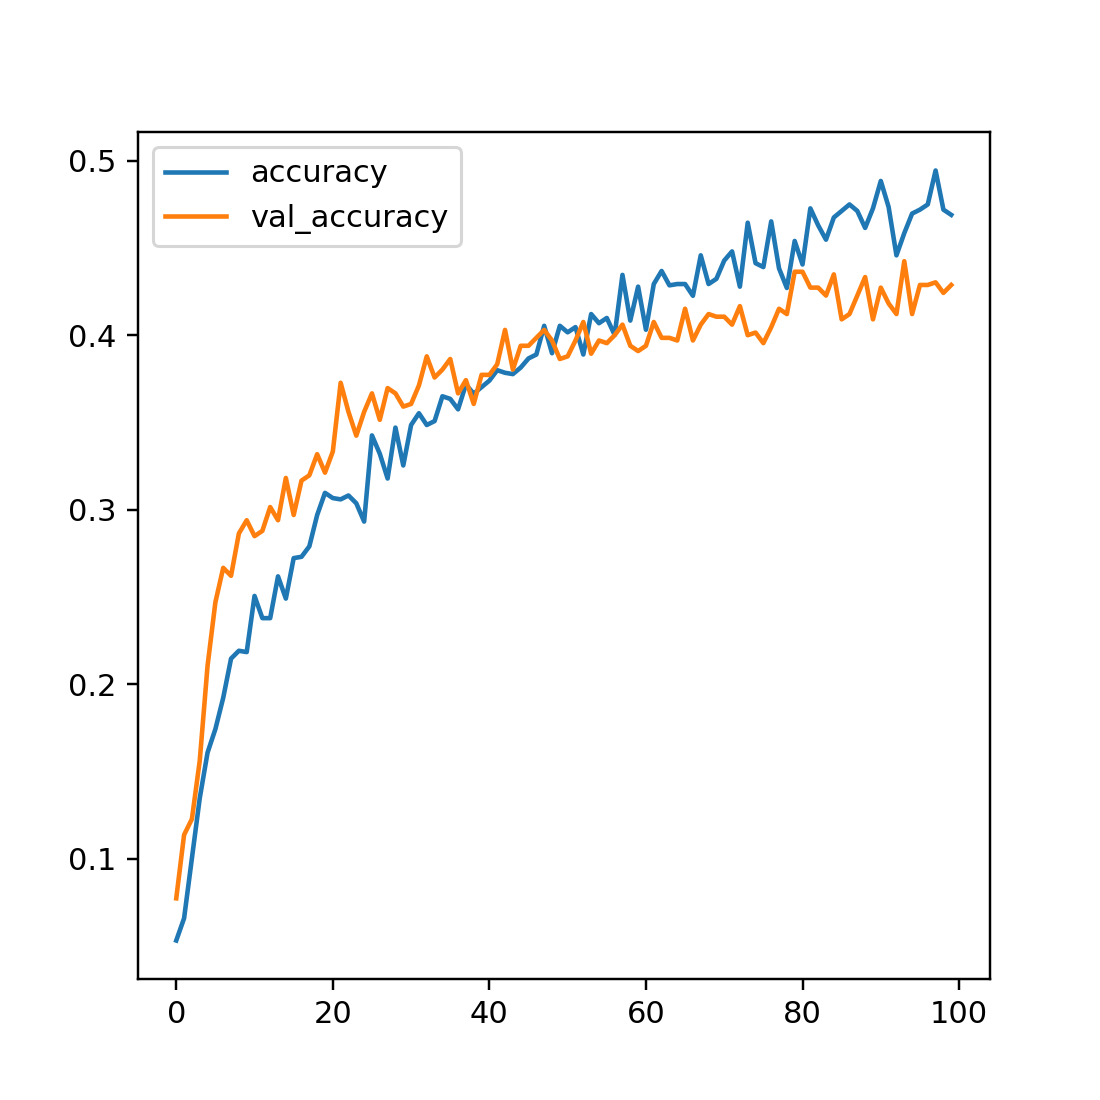

In [70]:
plt.figure(figsize=(5,5))
plt.plot(hist1.history["accuracy"], label="accuracy")
plt.plot(hist1.history["val_accuracy"], label="val_accuracy")

plt.legend()
plt.show()

#### RandomForest
* [1,10]
TRAIN: 0.788 ± 0.006
TEST : 0.275 ± 0.030
* [2,10]
TRAIN: 0.903 ± 0.005
TEST : 0.392 ± 0.054
* [16,10]
TRAIN: 0.994 ± 0.001
TEST : 0.531 ± 0.035

#### SVC 
```
kernel=linear
```

* [1,10]
TRAIN: 0.135 ± 0.009
TEST : 0.115 ± 0.016
* [2,10]
TRAIN: 0.216 ± 0.004
TEST : 0.181 ± 0.026
* [16,10]
TRAIN: 0.426 ± 0.007
TEST : 0.357 ± 0.032
* [16,10] **even dim.**
TRAIN: 0.382 ± 0.005
TEST : 0.325 ± 0.034

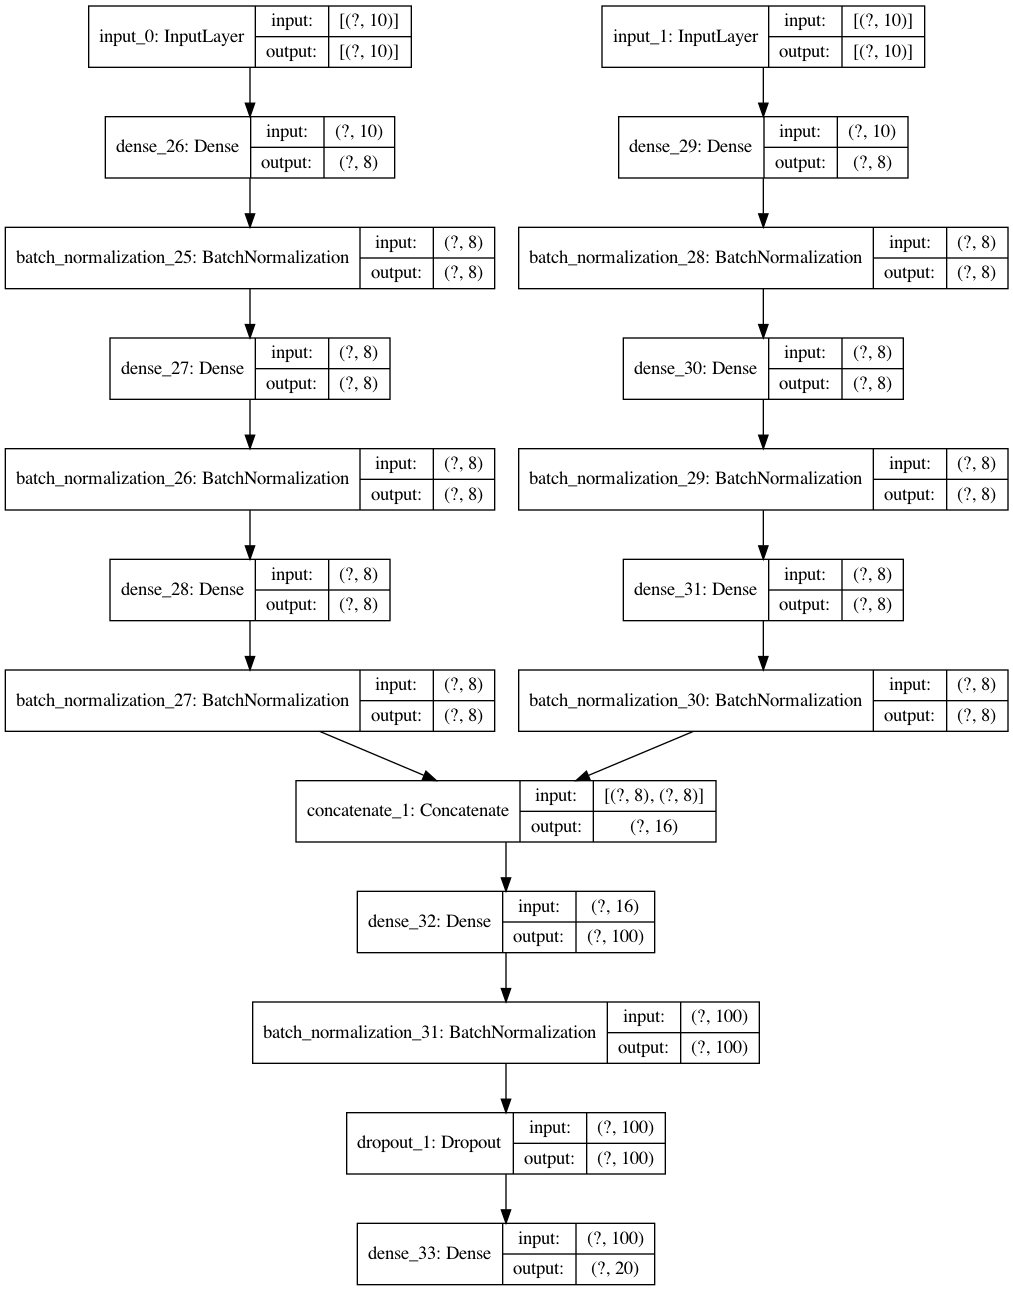

In [8]:
def build_submodel(x, n_layers=1, n_units=10, dr=0.2, bn=True):
    for i in range(n_layers):
        x = tf.keras.layers.Dense(
            n_units, 
            activation="relu", 
#             kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )(x)
        if bn:
            x = tf.keras.layers.BatchNormalization()(x)
        if dr > 0:
            x = tf.keras.layers.Dropout(dr)(x)
    return x

shape = np.shape(V)[-1]
n_dir = 2 # np.shape(V)[-2]

sub_inputs = []
sub_outputs = []
for i in range(n_dir):
    input_i = tf.keras.layers.Input(shape=(shape,), name=f"input_{i}")
    sub_inputs.append(input_i)

    sub_i = build_submodel(input_i, 3, 8, dr=0)
    sub_outputs.append(sub_i)

merge = tf.keras.layers.Concatenate()(sub_outputs)
# merge = tf.keras.layers.Add()(sub_outputs)
# merge = tf.keras.layers.Activation("relu")(merge)

x = build_submodel(merge, 1, 100, 0.25)
# x = build_submodel(x, 1, 100, 0.25)
# x = build_submodel(x, 1, 70, 0, False)

outputs = tf.keras.layers.Dense(20)(x)


model = tf.keras.Model(inputs=sub_inputs, outputs=outputs)

tf.keras.utils.plot_model(model, show_shapes=True)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(V, y, test_size=0.1, random_state=42)

X_train = np.transpose(X_train, (1,0,2))
X_test = np.transpose(X_test, (1,0,2))

X_train = [x for x in X_train]
X_test = [x for x in X_test]

# for i, (x_train, x_test) in enumerate(zip(X_train, X_test)):
#     scaler = StandardScaler()
#     X_train[i] = scaler.fit_transform(x_train)
#     X_test[i] = scaler.transform(x_test)

In [79]:
%timeit

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

opt_fn = tf.keras.optimizers.Adam(
    learning_rate=0.01
)
model.compile(optimizer=opt_fn,
              loss=loss_fn,
              metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1,
    patience=10, 
)

histn = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=32,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[reduce_lr]
)

Epoch 1/100
57/57 [==============================] - 1s 24ms/step - loss: 0.6473 - accuracy: 0.7839 - val_loss: 6.0107 - val_accuracy: 0.2750
Epoch 2/100
57/57 [==============================] - 0s 5ms/step - loss: 0.6797 - accuracy: 0.7744 - val_loss: 3.5330 - val_accuracy: 0.4250
Epoch 3/100
57/57 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.7667 - val_loss: 4.2946 - val_accuracy: 0.3500
Epoch 4/100
57/57 [==============================] - 0s 5ms/step - loss: 0.6253 - accuracy: 0.7906 - val_loss: 1.7808 - val_accuracy: 0.5800
Epoch 5/100
57/57 [==============================] - 0s 5ms/step - loss: 0.6352 - accuracy: 0.7850 - val_loss: 5.7064 - val_accuracy: 0.1950
Epoch 6/100
57/57 [==============================] - 0s 6ms/step - loss: 0.5914 - accuracy: 0.8017 - val_loss: 2.4098 - val_accuracy: 0.4850
Epoch 7/100
57/57 [==============================] - 0s 5ms/step - loss: 0.6449 - accuracy: 0.7700 - val_loss: 8.3675 - val_accuracy: 0.1850
Epoch 8/100


Epoch 59/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3410 - accuracy: 0.8822 - val_loss: 1.2997 - val_accuracy: 0.6950
Epoch 60/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3399 - accuracy: 0.8856 - val_loss: 1.3024 - val_accuracy: 0.6950
Epoch 61/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3690 - accuracy: 0.8756 - val_loss: 1.3011 - val_accuracy: 0.7000
Epoch 62/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3810 - accuracy: 0.8806 - val_loss: 1.3020 - val_accuracy: 0.7000
Epoch 63/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3762 - accuracy: 0.8689 - val_loss: 1.3019 - val_accuracy: 0.7000
Epoch 64/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3825 - accuracy: 0.8667 - val_loss: 1.3009 - val_accuracy: 0.7000
Epoch 65/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3662 - accuracy: 0.8767 - val_loss: 1.3020 - val_accuracy: 0.7000
Epoch 

In [80]:
compute_max = True
if compute_max:
    acc = max(histn.history["accuracy"])
    val_acc = max(histn.history["val_accuracy"])
else:
    acc = histn.history["accuracy"][-1]
    val_acc = histn.history["val_accuracy"][-1]
print(f"acc: {acc:.2f}")
print(f"val acc: {val_acc:.2f}")

acc: 0.89
val acc: 0.71


<IPython.core.display.Javascript object>


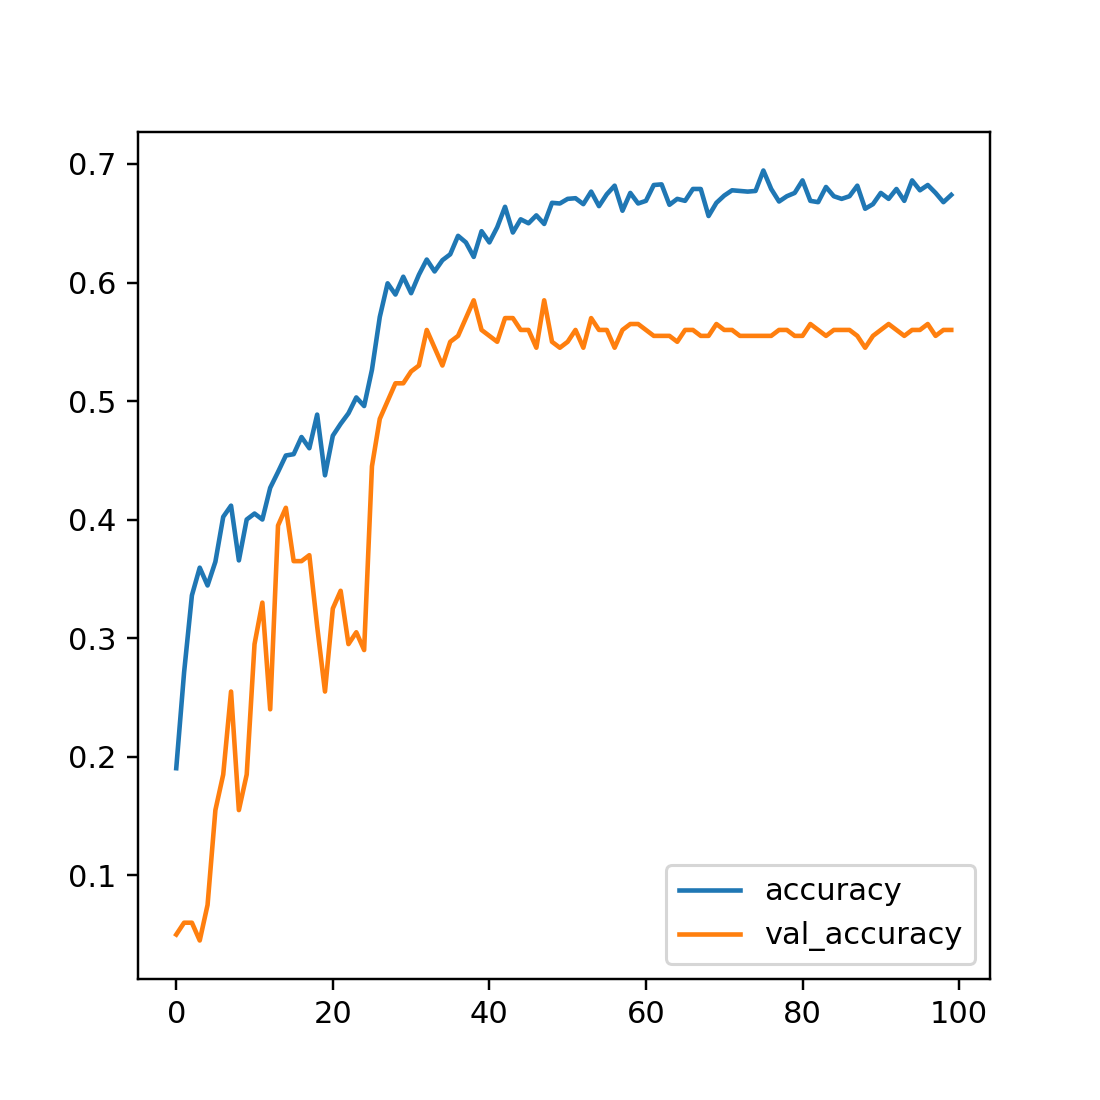

In [192]:
plt.figure(figsize=(5,5))
plt.plot(histn.history["accuracy"], label="accuracy")
plt.plot(histn.history["val_accuracy"], label="val_accuracy")

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


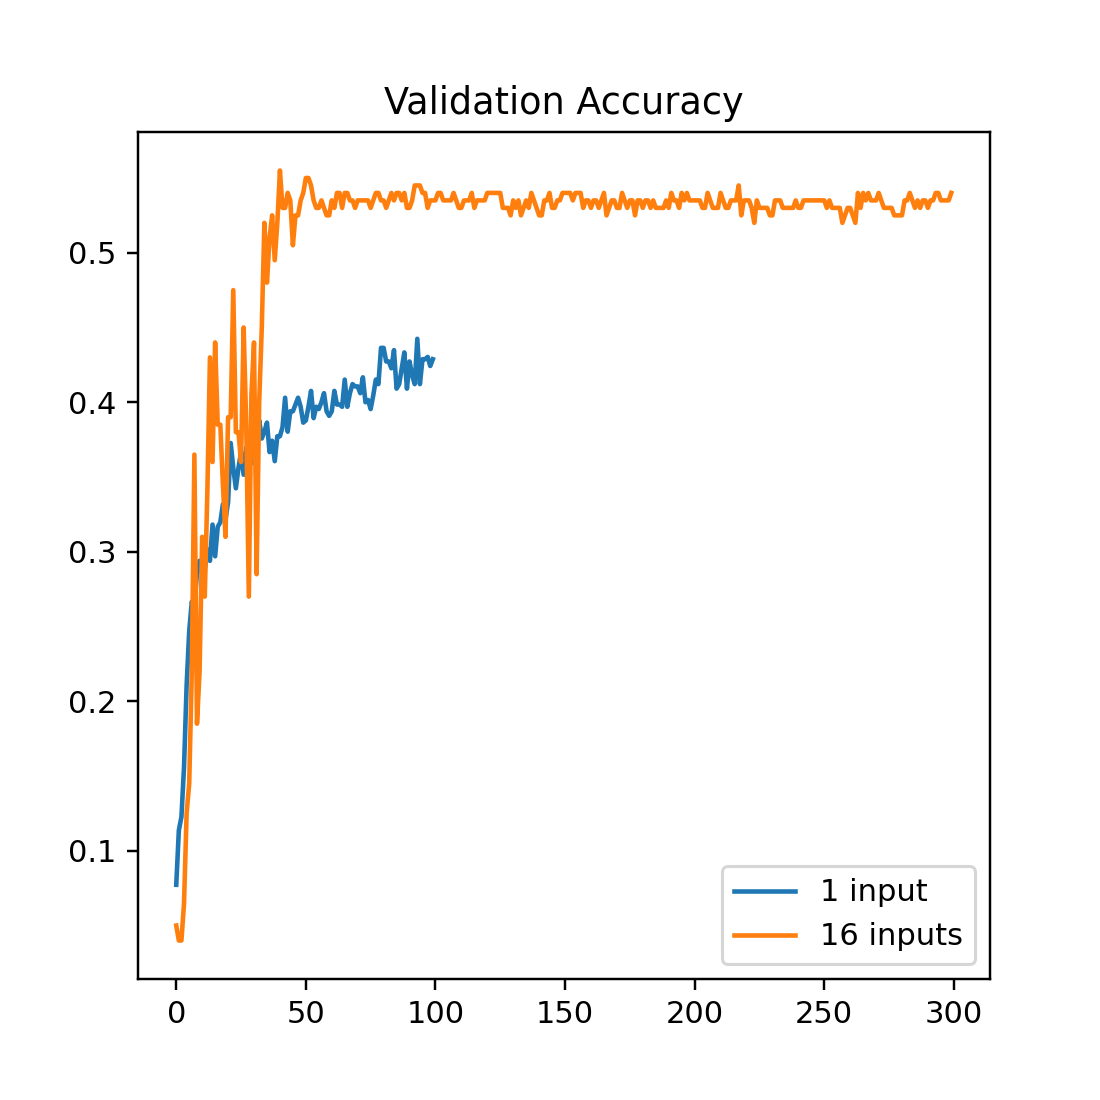

In [151]:
plt.figure(figsize=(5,5))
plt.plot(hist1.history["val_accuracy"], label="1 input")
plt.plot(histn.history["val_accuracy"], label=f"{n_dir} inputs")

plt.title("Validation Accuracy")

plt.legend()
plt.show()

In [174]:
-1%16

15

In [3]:
import core.config as config
from core.utils import *

from chofer_tda_datasets import Animal

used_directions = ['dim_0_dir_{}'.format(i) for i in range(0, 32,2)]
dataset = Animal(root_dir=config.paths.data_root_dir)

Found data!


In [48]:
X = [[(x[f"dim_0_dir_{i}"],x[f"dim_1_dir_{i}"]) for i in range(32)] for x,_ in dataset]
y = [label for _, label in dataset]

print(np.shape(X))
print(np.shape(y))

(2000, 32, 2)
(2000,)


In [49]:
X[0][0]

(array([[0.6617386 , 0.67436188],
        [0.26158052, 0.73874062]]),
 array([], dtype=float64))